<a href="https://colab.research.google.com/github/ViniciusCastillo/BootcampAlura_Proj6_Concessao_Credito/blob/main/Notebooks/Analise_Base_Clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math as math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
# define cores
cinza1, cinza2, cinza3 = '#E5E5E5', '#D8D8D8', '#BFBEBE'
cinza4, cinza5, cinza6 = '#929497', '#808080', '#76787B'
cinza7, cinza8, cinza9 = '#646369', '#555655', '#414040'
amarelo1, amarelo2, amarelo3 = '#FFFFCC', '#FFFF66', '#FFFF00'
amarelo4, amarelo5, amarelo6 = '#CCCC00', '#999900', '#666600'
laranja1, laranja2, laranja3 = '#FFA500', '#FF8C00', '#FF4500'
verde1, verde2 = '#32CD32', '#ADFF2F'

plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['ytick.color'] = cinza4
plt.rcParams['xtick.color'] = cinza4
plt.rcParams['legend.edgecolor'] = cinza6
plt.rcParams['legend.facecolor'] = 'black'
plt.rcParams['text.color'] = cinza3

In [ ]:
def negrito(texto):
  return '$\\bf{'+texto.replace(' ','\ ')+'}$'

def formatar_grafico(ax, xlimite, ylimite, cor=cinza4, fonte=13):
  ax.spines['bottom'].set_color(cor)
  ax.spines['left'].set_color(cor)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.tick_params(bottom=False, color=cor)
  ax.set_xlim(xlimite)
  ax.set_ylim(ylimite)
  for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(fonte)
    i.set_color(cor)
  plt.xlabel('')

def colorir_legenda(legenda, cores, cortitulo=cinza4):
  legenda.get_title().set_color(cortitulo)
  i = 0
  for texto in legenda.get_texts():
    texto.set_color(cores[i])
    i+=1

def legenda_linhas(ax, serie, cores, distancia, ajuste=0, ajuste_ind=[0]):
  ajuste_ = ajuste
  i = 0
  for valor in serie.index:
    if len(ajuste_ind) == len(serie):
      ajuste_ = ajuste + ajuste_ind[i]
    ax.text(distancia, serie.loc[valor]+ajuste_, negrito(valor), fontsize=10, color=cores[i])
    i+=1

def plota_seta(distancia, inicial, final, cor, horientacao='v', ls=':', lw=.5):
  if horientacao == 'v':
    plt.arrow(x=distancia, y=inicial, dx=0, dy=final-inicial, color=cor, ls=ls, 
              lw=lw, head_width=.5, head_length=.3, length_includes_head=True)
  elif horientacao == 'h':
    plt.arrow(y=distancia, x=inicial, dy=0, dx=final-inicial, color=cor, ls=ls, 
              lw=lw, head_width=.5, head_length=.3, length_includes_head=True)
  else:
    print('Valor do parâmentro horientação inexistente')

def hist_box_plot (serie, corInterna=laranja1, corContorno=cinza6, bins=30):
  fig = plt.figure(figsize=(10,5))
  sns.histplot(x=serie,bins=bins, color=corInterna)
  plt.show()
  fig = plt.figure(figsize=(7,7))
  sns.boxplot(y=serie, boxprops = dict(color=corInterna, linestyle='-', linewidth=3, edgecolor=corContorno),
              medianprops = dict(color=corContorno, linewidth=3),
              flierprops = dict(marker='o', markerfacecolor=corInterna, markersize=12, linestyle='none'),
              whiskerprops = dict(color=corContorno, linewidth=3),
              capprops = dict(color=corContorno, linewidth=3))
  plt.show()

In [ ]:
df_clientes = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/Avaliacao_Credito/main/dados/clientes_cadastrados.csv')
print('formato: ',df_clientes.shape,'\n')
df_clientes.head()

formato:  (438557, 18) 



,ID_Cliente,Genero,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_Celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
0,5008804,H,1,1,0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1,1,0,0,Outros,2.0,12.4
1,5008805,H,1,1,0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1,1,0,0,Outros,2.0,12.4
2,5008806,H,1,1,0,112500.0,Empregado,Ensino medio,Casado,Casa propria,59.0,1,0,0,0,Seguranca,2.0,3.1
3,5008808,M,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,1,0,1,1,Venda,1.0,8.4
4,5008809,M,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,1,0,1,1,Venda,1.0,8.4


In [ ]:
df_clientes['ID_Cliente'].value_counts().to_frame()

,ID_Cliente
7137299,2
7702238,2
7282535,2
7243768,2
7050948,2
...,...
5690727,1
6621262,1
6621261,1
6621260,1


In [ ]:
df_clientes.duplicated().sum()

0

In [ ]:
id_repetidos = df_clientes[df_clientes['ID_Cliente'].duplicated(keep=False)]['ID_Cliente'].to_frame()
id_repetidos

,ID_Cliente
421211,7702516
421268,7602432
421349,7602432
421464,7836971
421698,7213374
...,...
433158,7282535
433159,7742853
433217,7135270
433666,7091721


In [ ]:
analise = df_clientes[df_clientes.ID_Cliente.duplicated(keep=False)].sort_values('ID_Cliente')
analise.head(6)

,ID_Cliente,Genero,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_Celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
426818,7022197,H,1,1,3,135000.0,Empregado,Ensino medio,Casado,Casa propria,33.0,1,0,0,1,Construcao Civil,5.0,2.0
425023,7022197,M,0,1,0,450000.0,Associado comercial,Ensino superior,Separado,Casa propria,54.0,1,0,0,1,Outros,1.0,4.9
431545,7022327,M,0,1,0,135000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,40.0,1,0,0,0,Alta tecnologia,1.0,14.5
431911,7022327,H,1,1,0,256500.0,Associado comercial,Ensino superior,Casado,Casa propria,59.0,1,0,0,1,Equipe principal,2.0,4.6
425486,7023108,H,1,1,1,67500.0,Empregado,Ensino medio,Casado,Casa propria,42.0,1,1,0,0,Equipe principal,3.0,4.6
426488,7023108,M,0,0,0,135000.0,Empregado,Ensino medio,Casado,Casa propria,48.0,1,0,0,0,Limpeza,2.0,3.5


In [ ]:
analise.tail(6)

,ID_Cliente,Genero,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_Celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
426714,7836711,H,1,0,2,315000.0,Servidor publico,Ensino superior,Casado,Casa propria,32.0,1,1,1,0,Gerencia,4.0,4.2
426563,7836711,M,0,1,2,292500.0,Empregado,Ensino superior,Casado,Casa propria,38.0,1,0,1,0,Contabilidade,4.0,12.0
421464,7836971,H,1,0,1,157500.0,Empregado,Ensino medio,Casado,Casa propria,38.0,1,0,0,0,Outros,3.0,15.1
428620,7836971,M,0,1,0,103500.0,Empregado,Ensino medio,Uniao estavel,Casa propria,37.0,1,0,1,0,Venda,2.0,7.7
422068,7838075,H,0,1,0,337500.0,Associado comercial,Ensino medio,Casado,Casa propria,50.0,1,0,0,1,Motorista,2.0,3.5
423702,7838075,M,1,1,0,315000.0,Associado comercial,Ensino superior,Solteiro,Casa propria,29.0,1,0,0,1,Outros,1.0,4.5


In [ ]:
df_clientes_unicos = df_clientes.drop(id_repetidos.index)
df_clientes_unicos['ID_Cliente'].value_counts().to_frame()

,ID_Cliente
5008804,1
6147691,1
6147689,1
6147688,1
6147685,1
...,...
6093492,1
5690720,1
6538938,1
6538937,1


In [ ]:
df_clientes_unicos.isnull().sum().to_frame().T

,ID_Cliente,Genero,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_Celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
descricao = df_clientes_unicos.describe().T
print('colunas que não sofrem variação:\n')
descricao[descricao['min'] == descricao['max']][['min','max']]

colunas que não sofrem variação:



,min,max
Tem_Celular,1.0,1.0


In [ ]:
# remove a coluna que não tem variação e Genero que não pode ser utilizado em análises de concessão de crédito
df_clientes_ajustado = df_clientes_unicos.drop(['Genero','Tem_Celular'], axis=1).set_index('ID_Cliente')
df_clientes_ajustado.head()

,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
ID_Cliente,,,,,,,,,,,,,,,
5008804,1,1,0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1,0,0,Outros,2.0,12.4
5008805,1,1,0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1,0,0,Outros,2.0,12.4
5008806,1,1,0,112500.0,Empregado,Ensino medio,Casado,Casa propria,59.0,0,0,0,Seguranca,2.0,3.1
5008808,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,0,1,1,Venda,1.0,8.4
5008809,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,0,1,1,Venda,1.0,8.4


## Inicio das análises com a variável alvo

In [ ]:
df_alvo = pd.read_csv('https://github.com/ViniciusCastillo/BootcampAlura_Proj6_Concessao_Credito/raw/main/dados/target.cvs')
print('formato: ',df_alvo.shape,'\n')
df_alvo.head()

formato:  (29581, 2) 



,ID_Cliente,Risco
0,5001712,0
1,5001713,0
2,5001714,0
3,5001715,0
4,5001717,0


In [ ]:
df_analise = df_alvo.join(df_clientes_ajustado, on='ID_Cliente')
print('formato: ',df_analise.shape,'\n')
df_analise.head()

formato:  (29581, 17) 



,ID_Cliente,Risco,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
0,5001712,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5001713,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5001714,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5001715,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5001717,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_analise.isnull().sum().to_frame().T

,ID_Cliente,Risco,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
0,0,0,7291,7291,7291,7291,7291,7291,7291,7291,7291,7291,7291,7291,7291,7291,7291


In [ ]:
df_analise_ajust = df_analise.dropna().copy()
print('formato: ',df_analise_ajust.shape,'\n')
df_analise_ajust.head()

formato:  (22290, 17) 



,ID_Cliente,Risco,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
2507,5008804,0,1.0,1.0,0.0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1.0,0.0,0.0,Outros,2.0,12.4
2508,5008805,0,1.0,1.0,0.0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1.0,0.0,0.0,Outros,2.0,12.4
2509,5008806,0,1.0,1.0,0.0,112500.0,Empregado,Ensino medio,Casado,Casa propria,59.0,0.0,0.0,0.0,Seguranca,2.0,3.1
2510,5008810,0,0.0,1.0,0.0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,0.0,1.0,1.0,Venda,1.0,8.4
2511,5008811,0,0.0,1.0,0.0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,0.0,1.0,1.0,Venda,1.0,8.4


In [ ]:
df_analise_ajust.isnull().sum().to_frame().T

,ID_Cliente,Risco,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
descricao_objetos = df_analise_ajust.describe(include='O').T
print('colunas categóricas com concentração acima de 80% em uma única categoria:\n')
descricao_objetos[descricao_objetos['freq'] > descricao_objetos['count']*.8]

colunas categóricas com concentração acima de 80% em uma única categoria:



,count,unique,top,freq
Moradia,22290,6,Casa propria,19930


In [ ]:
df_analise_ajust.Moradia.value_counts(normalize=True).to_frame()

,Moradia
Casa propria,0.894123
Mora com os pais,0.046972
Habitacao publica,0.032481
Alugado,0.014491
Apartamento comercial,0.007178
Cooperativa habitacional,0.004755


Podemos conferir uma grande concentação em apenas uma categoria, vamos precisar prestar mais atenção em moradia nas avaliações futuras

In [ ]:
descricao_numericas = df_analise_ajust.iloc[:,2:].describe().T
print('colunas numéricas com valor min abaixo da média menos 2 desvios padrão:\n')
descricao_numericas[descricao_numericas['min']<(descricao_numericas['mean']-2*descricao_numericas['std'])][['min','mean','std','max']]

colunas numéricas com valor min abaixo da média menos 2 desvios padrão:



,min,mean,std,max
Idade,21.0,44.064872,11.248334,69.0
Anos_empregado,-1000.7,-154.413015,370.306586,43.0


In [ ]:
df_outlier0 = df_analise_ajust[df_analise_ajust.Anos_empregado == -1000.7]
print('formato: ',df_outlier0.shape,'\n')
df_outlier0.head()

formato:  (3581, 17) 



,ID_Cliente,Risco,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
2512,5008812,0,0.0,1.0,0.0,283500.0,Pensionista,Ensino superior,Separado,Casa propria,62.0,0.0,0.0,0.0,Outros,1.0,-1000.7
2513,5008813,0,0.0,1.0,0.0,283500.0,Pensionista,Ensino superior,Separado,Casa propria,62.0,0.0,0.0,0.0,Outros,1.0,-1000.7
2514,5008814,0,0.0,1.0,0.0,283500.0,Pensionista,Ensino superior,Separado,Casa propria,62.0,0.0,0.0,0.0,Outros,1.0,-1000.7
2517,5008827,1,1.0,1.0,0.0,180000.0,Pensionista,Ensino superior,Casado,Casa propria,51.0,0.0,0.0,0.0,Outros,2.0,-1000.7
2543,5008884,0,0.0,1.0,0.0,315000.0,Pensionista,Ensino medio,Viuvo,Casa propria,55.0,0.0,0.0,0.0,Outros,1.0,-1000.7


In [ ]:
df_outlier0.Categoria_de_renda.value_counts().to_frame()

,Categoria_de_renda
Pensionista,3581


In [ ]:
df_analise_ajust.loc[df_analise_ajust.Categoria_de_renda == 'Pensionista', 'Anos_empregado'].value_counts(normalize=True).to_frame().head(10)

,Anos_empregado
-1000.7,0.995829
1.8,0.000556
1.6,0.000278
1.9,0.000278
2.5,0.000278
4.5,0.000278
6.0,0.000278
10.1,0.000278
1.2,0.000278
1.7,0.000278


In [ ]:
df_analise_ajust.loc[df_analise_ajust.Anos_empregado < 0,'Anos_empregado'].value_counts().to_frame()

,Anos_empregado
-1000.7,3581


In [ ]:
# Vamos alterar o outlier para -1, dado que aparenta ter uma relação com quem é pensionista 
# e pode ser importante manter essa distinção.
df_analise_ajust.Anos_empregado.replace(-1000.7, -1, inplace=True)

In [ ]:
# Vamos conferir novamente
descricao_numericas = df_analise_ajust.iloc[:,2:].describe().T
print('colunas numéricas com valor min abaixo da média menos 2 desvios padrão:\n')
descricao_numericas[descricao_numericas['min']<(descricao_numericas['mean']-2*descricao_numericas['std'])][['min','mean','std','max']]

colunas numéricas com valor min abaixo da média menos 2 desvios padrão:



,min,mean,std,max
Idade,21.0,44.064872,11.248334,69.0


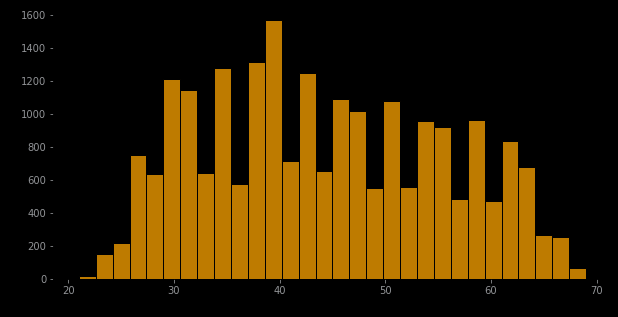

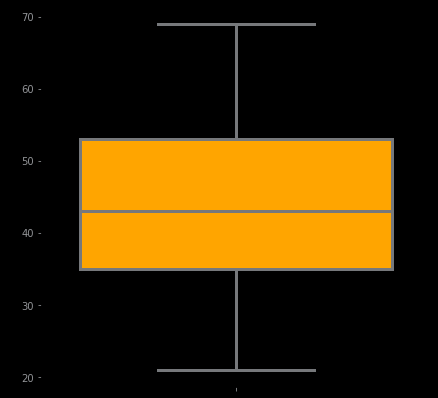

In [ ]:
hist_box_plot(df_analise_ajust['Idade'])

In [ ]:
print('\ncolunas numéricas com valor max acima da média mais 2 desvios padrão:\n')
descricao_numericas[descricao_numericas['max']>(descricao_numericas['mean']+2*descricao_numericas['std'])][['min','mean','std','max']]


colunas numéricas com valor max acima da média mais 2 desvios padrão:



,min,mean,std,max
Qtd_Filhos,0.0,0.431045,0.737603,14.0
Rendimento_Anual,27000.0,189400.622342,102167.066104,1575000.0
Idade,21.0,44.064872,11.248334,69.0
Tem_email,0.0,0.092418,0.289622,1.0
Tamanho_Familia,1.0,2.209735,0.903145,15.0
Anos_empregado,-1.0,6.193791,6.782059,43.0


In [ ]:
df_analise_ajust.Tem_email.value_counts(normalize=True).to_frame()*100

,Tem_email
0.0,90.758188
1.0,9.241812


Podemos conferir uma grande concentação em apenas uma categoria, vamos precisar prestar mais atenção em Tem_email nas avaliações futuras

In [ ]:
df_analise_ajust.Qtd_Filhos.value_counts(normalize=True).to_frame()*100

,Qtd_Filhos
0.0,69.143114
1.0,20.363392
2.0,9.098250
3.0,1.184388
4.0,0.161507
5.0,0.031404
14.0,0.008973
7.0,0.008973


In [ ]:
df_analise_ajust.Tamanho_Familia.value_counts(normalize=True).to_frame()*100

,Tamanho_Familia
2.0,54.131898
1.0,18.295200
3.0,17.559444
4.0,8.667564
5.0,1.144011
6.0,0.157021
7.0,0.026918
15.0,0.008973
9.0,0.008973


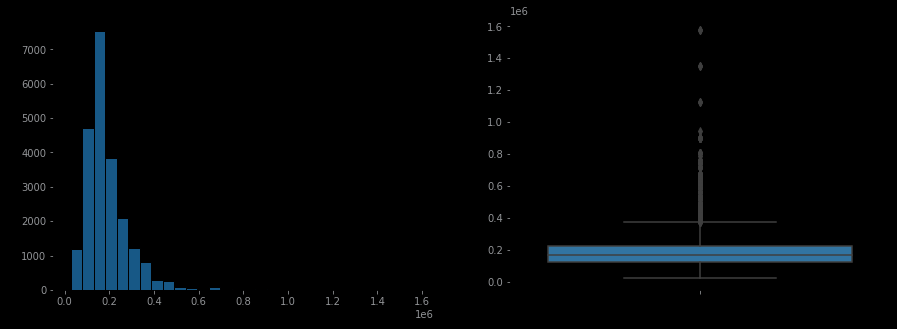

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1, ax2 = fig.subplots(1, 2)
sns.histplot(x=df_analise_ajust['Rendimento_Anual'],bins=30, ax=ax1)
sns.boxplot(y=df_analise_ajust['Rendimento_Anual'], ax=ax2)

In [ ]:
df_analise_ajust.Rendimento_Anual.value_counts(normalize=True).to_frame().head(10)*100

,Rendimento_Anual
135000.0,11.395245
180000.0,8.815612
157500.0,8.061911
225000.0,7.909376
112500.0,7.815164
202500.0,6.150740
270000.0,4.939435
90000.0,4.751009
315000.0,3.064154
67500.0,2.386721


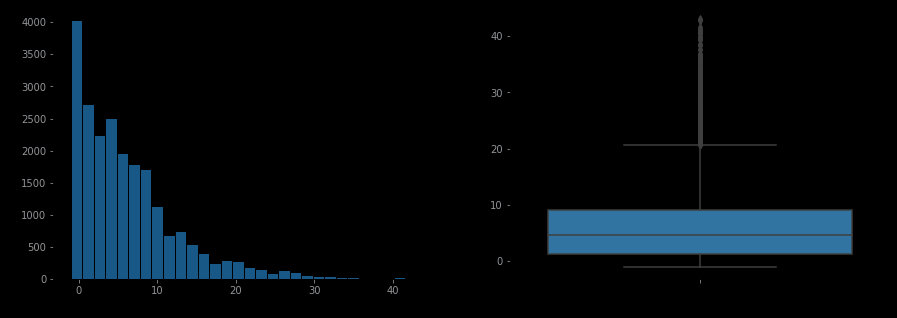

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1, ax2 = fig.subplots(1, 2)
sns.histplot(x=df_analise_ajust['Anos_empregado'],bins=30, ax=ax1)
sns.boxplot(y=df_analise_ajust['Anos_empregado'], ax=ax2)

In [ ]:
df_analise_ajust.Anos_empregado.value_counts(normalize=True).to_frame().head(10)*100

,Anos_empregado
-1.0,16.065500
0.8,1.076716
0.3,1.067743
1.8,1.036339
1.1,1.018394
4.6,0.995962
2.0,0.982503
1.0,0.982503
3.3,0.973531
0.6,0.964558


In [ ]:
categoricas_n_bin = set(df_clientes_unicos.describe(include='O').T.index)
binarias = {cat for cat in df_clientes_unicos.columns if cat.rfind('Tem')!=-1}
categoricas = categoricas_n_bin.union(binarias)
quantitativas = set(df_clientes_unicos.columns) - categoricas - {'ID_Cliente, Risco'}
print(f'categoricas: {categoricas}\nquantitativas: {quantitativas}')

categoricas: {'Tem_Casa_Propria', 'Tem_telefone_trabalho', 'Tem_Celular', 'Categoria_de_renda', 'Tem_telefone_fixo', 'Ocupacao', 'Moradia', 'Tem_Carro', 'Grau_Escolaridade', 'Tem_email', 'Genero', 'Estado_Civil'}
quantitativas: {'ID_Cliente', 'Rendimento_Anual', 'Idade', 'Anos_empregado', 'Qtd_Filhos', 'Tamanho_Familia'}
